In [1100]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os,glob
import tifffile as tf
from matplotlib.gridspec import GridSpec as gs
import pickle as pk
from scipy.stats import pearsonr

## Render pulse-chase RGB images

In [1]:
def render_rgb(data, 
               nada_range = (2000,6000),
               hada_range= (200,8000)):
    n,h,w = data.shape
    rgb = np.zeros((h,w,3))
    nada = adjust_contrast(data[1],nada_range[0],nada_range[1])
    hada = adjust_contrast(data[3],hada_range[0],hada_range[1])
    rgb[:,:,0]+=nada
    rgb[:,:,1]+=0.95*hada
    rgb[:,:,2]+=np.max(np.array([nada,hada]),axis=0)
    rgb[:,:,2]/=rgb[:,:,2].max()
    return (rgb)

def min_max(data):
    return (data-data.min())/(data.max()-data.min())

def adjust_contrast(data, vmin,vmax):
    as_float = data.copy().astype(float)
    new_data = (as_float-vmin)/(vmax-vmin)
    new_data[new_data>1]=1
    new_data[new_data<0]=0
    return new_data

def reorient_data(data, direction='left'):
    half_l = int(round(len(data)/2))
    if direction == 'left':
        flip = bool(data[:half_l].mean()<data.mean())
    elif direction == 'right':
        flip = bool(data[:half_l].mean()>data.mean())
    if flip:
        data = np.flip(data)
    return data, flip 

def percentile_norm(data,low_perc = 2.5,high_perc=97.5):
    p1 = np.percentile(data,low_perc)
    p2 = np.percentile(data,high_perc)
    norm_d = (data-p1)/(p2-p1)
    norm_d[norm_d>1]=1
    norm_d[norm_d<0]=0
    return norm_d

def one_sided_constrast(data,vmin=200,vmax=3000):
    vmax = max(np.percentile(data,95),vmax)
    return adjust_contrast(data,vmin,vmax)

def fill_polesections(b,max_pole_range=20,reject_pole_dist=20):
    outgrowth = np.where(b>0)[0]
    filled = np.zeros(b.shape)
    if len(outgrowth)>5:
        filled[outgrowth]=1
        if outgrowth[0]<=max_pole_range:
            filled[:outgrowth[0]]=1
        if outgrowth[-1]>=len(b)-max_pole_range:
            filled[outgrowth[-1]:]=1
        if min(outgrowth[0],len(b)-outgrowth[-1])>=reject_pole_dist:
            filled*=0
    return filled

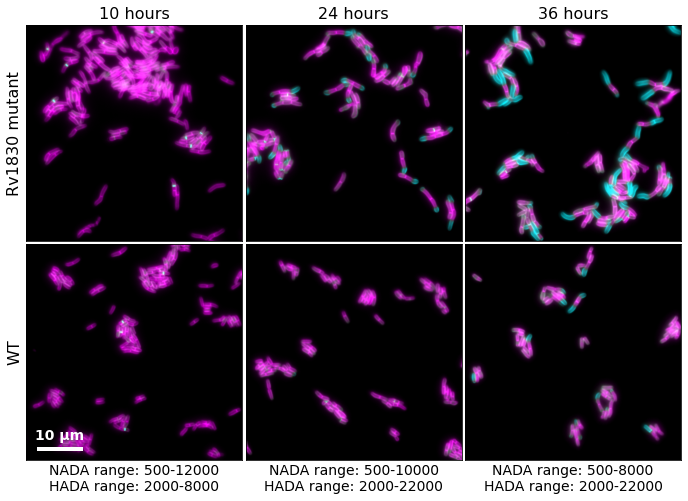

In [199]:
r8_inh_36h = tf.imread('/Users/jz-rolling/Desktop/Rv1830_manuscript/figures/Fig3_raw/R8_INH_pulsechase_36hours_04.tif')
n1_inh_36h = tf.imread('/Users/jz-rolling/Desktop/Rv1830_manuscript/figures/Fig3_raw/N1_INH_pulsechase_36hours_09.tif')
r8_inh_24h = tf.imread('/Users/jz-rolling/Desktop/Rv1830_manuscript/figures/Fig3_raw/R8_INH_pulsechase_24hours_06.tif')
n1_inh_24h = tf.imread('/Users/jz-rolling/Desktop/Rv1830_manuscript/figures/Fig3_raw/N1_INH_pulsechase_24hours_07.tif')
r8_inh_10h = tf.imread('/Users/jz-rolling/Desktop/Rv1830_manuscript/figures/Fig3_raw/R8_INH_pulsechase_10hours_02.tif')
n1_inh_10h = tf.imread('/Users/jz-rolling/Desktop/Rv1830_manuscript/figures/Fig3_raw/N1_INH_pulsechase_10hours_03.tif')

fig=plt.figure(figsize=(11.8,8))
grids = gs(2,3,hspace=0.015,wspace=0.00)
nc_list = [r8_inh_10h,r8_inh_24h,r8_inh_36h,n1_inh_10h,n1_inh_24h,n1_inh_36h]
nada_ranges=[[500,12000],
             [500,10000],
             [500,8000]]

hada_ranges=[[2000,8000],
             [2000,22000],
             [2000,22000]]
times = ['10 hours','24 hours','36 hours']
strains = ['Rv1830 mutant','WT']

for i in range(6):
    r = int(i/3)
    c = i%3
    ax = fig.add_subplot(grids[r,c])
    ax.imshow(render_rgb(nc_list[i],
                         nada_range=nada_ranges[c],
                         hada_range=hada_ranges[c]))
    ax.set_xticks([])
    ax.set_yticks([])
    if c==0:
        ax.set_ylabel(strains[r],fontsize=16,fontname='Aria')
    if r==0:
        ax.set_title(times[c],fontsize=16,fontname='Aria')
    if r==1:
        ax.set_xlabel('NADA range: {}-{}\nHADA range: {}-{}'.format(nada_ranges[c][0],
                                                                    nada_ranges[c][1],
                                                                    hada_ranges[c][0],
                                                                    hada_ranges[c][1]),fontsize=14,fontname='Aria')
    if r==1 and c==0:
        ax.hlines(y=600,xmin=30,xmax=10+10/0.065,color='w',lw=4)
        ax.text(x=(30+10+10/0.065)/2,y=580,s='10 µm',fontname='Aria',fontsize=14,color='w',ha='center',va='bottom',fontweight='bold')
plt.savefig('/Users/jz-rolling/Desktop/Rv1830_manuscript/figures/Fig3F_INH.png',dpi=300,bbox_inches='tight')

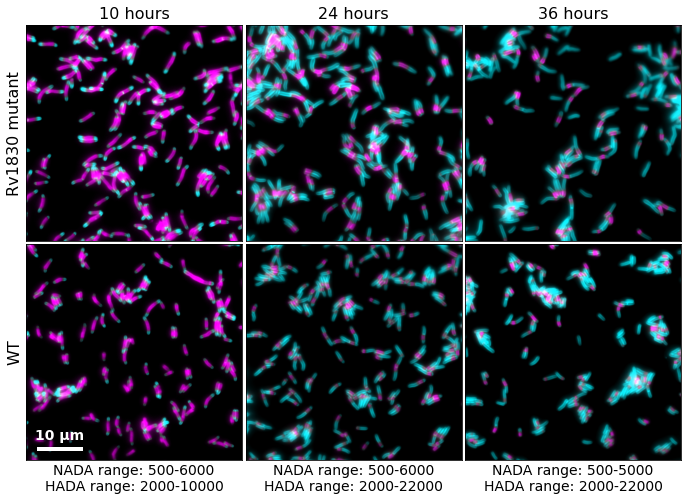

In [200]:
n1_nc_10h = tf.imread('/Users/jz-rolling/Desktop/Rv1830_manuscript/figures/Fig3_raw/N1_NC_pulsechase_10hours_05.tif')
n1_nc_24h = tf.imread('/Users/jz-rolling/Desktop/Rv1830_manuscript/figures/Fig3_raw/N1_NC_pulsechase_24hours_05.tif')
n1_nc_36h = tf.imread('/Users/jz-rolling/Desktop/Rv1830_manuscript/figures/Fig3_raw/N1_NC_pulsechase_36hours_03.tif')
r8_nc_10h = tf.imread('/Users/jz-rolling/Desktop/Rv1830_manuscript/figures/Fig3_raw/R8_NC_pulsechase_10hours_01.tif')
r8_nc_24h = tf.imread('/Users/jz-rolling/Desktop/Rv1830_manuscript/figures/Fig3_raw/R8_NC_pulsechase_24hours_02.tif')
r8_nc_36h = tf.imread('/Users/jz-rolling/Desktop/Rv1830_manuscript/figures/Fig3_raw/R8_NC_pulsechase_36hours_03.tif')
fig=plt.figure(figsize=(11.8,8))
grids = gs(2,3,hspace=0.015,wspace=0.00)
nc_list = [r8_nc_10h,r8_nc_24h,r8_nc_36h,n1_nc_10h,n1_nc_24h,n1_nc_36h]
nada_ranges=[[500,6000],
             [500,6000],
             [500,5000]]

hada_ranges=[[2000,10000],
             [2000,22000],
             [2000,22000]]
times = ['10 hours','24 hours','36 hours']
strains = ['Rv1830 mutant','WT']

for i in range(6):
    r = int(i/3)
    c = i%3
    ax = fig.add_subplot(grids[r,c])
    ax.imshow(render_rgb(nc_list[i],
                         nada_range=nada_ranges[c],
                         hada_range=hada_ranges[c]))
    ax.set_xticks([])
    ax.set_yticks([])
    if c==0:
        ax.set_ylabel(strains[r],fontsize=16,fontname='Aria')
    if r==0:
        ax.set_title(times[c],fontsize=16,fontname='Aria')
    if r==1:
        ax.set_xlabel('NADA range: {}-{}\nHADA range: {}-{}'.format(nada_ranges[c][0],
                                                                    nada_ranges[c][1],
                                                                    hada_ranges[c][0],
                                                                    hada_ranges[c][1]),fontsize=14,fontname='Aria')
    if r==1 and c==0:
        ax.hlines(y=600,xmin=30,xmax=10+10/0.065,color='w',lw=4)
        ax.text(x=(30+10+10/0.065)/2,y=580,s='10 µm',fontname='Aria',fontsize=14,color='w',ha='center',va='bottom',fontweight='bold')
plt.savefig('/Users/jz-rolling/Desktop/Rv1830_manuscript/figures/Fig3F_NC.png',dpi=300,bbox_inches='tight')

## Calculate pole-outgrowth stats

#### Load momia output

In [2]:
master_df = pd.read_csv('/Volumes/LaCie/QY_data/20211212_QY_pulsechase_output/QY_pulsechase_20211207_master_df_20220207_redo.csv')
midlines = pk.load(open('/Volumes/LaCie/QY_data/20211212_QY_pulsechase_output/QY_pulsechase_20211207_midlines_20220207_redo.pk','rb'))

#### Define helper funcs

In [ ]:
def pole_outgrowth(nada,hada,nada_q10_threshold=2000,hada_q10_threshold=2500):
    if np.percentile(nada,90)<nada_q10_threshold:
        return np.ones(len(nada))
    elif np.percentile(hada,90)<hada_q10_threshold:
        return np.zeros(len(nada))
    else:

def quantile_normalize(df):
    """
    input: dataframe with numerical columns
    output: dataframe with quantile normalized values
    """
    df_sorted = pd.DataFrame(np.sort(df.values,
                                     axis=0), 
                             index=df.index, 
                             columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn =df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return(df_qn)

def median_filter(data,window=5):
    convolved = np.zeros(data.shape)
    for i in range(len(data)):
        n = min(max(i,0),len(data)-window-1)
        convolved[i]=np.mean(data[n:n+window])
    return convolved

#### Calculate INH-treated pole-stats

In [2001]:
# final?
cond0 = master_df['Experiments']=='Exp B'
cond1 = master_df['Date_seeded']==20211209
pole_stat_selected = []
for condition in ['N.C.','INH']:
    cond2 = master_df['Antibiotics']==condition
    for t in ['T1','T2','T3']:
        cond3 = master_df['Time points']==t
        for strain in ['N1','R8']:
            cond4 = master_df['Strain']==strain
            subset = master_df[cond0&cond1&cond2&cond3&cond4].copy().set_index('Cell_id')
            selected_cells = []
            key = subset['key'].unique()[0]
            hada_stack=[]
            nada_stack=[]
            for k,d in midlines[key].items():
                hada = d['DAPI']
                nada,flip = reorient_data(d['FITC'],'right')
                if flip:
                    hada = np.flip(hada)
                if np.percentile(nada,95)>3000 or np.percentile(hada,95)>8000:
                    nada_stack.append(np.interp(np.linspace(0,1,100),xp=np.linspace(0,1,len(nada)),fp=nada))
                    hada_stack.append(np.interp(np.linspace(0,1,100),xp=np.linspace(0,1,len(hada)),fp=hada))
                    selected_cells.append(k)
            selected_cells = np.array(selected_cells)
            selected_df = subset.loc[selected_cells].copy()
            
            nada_stack=np.array(nada_stack)
            hada_stack=np.array(hada_stack)
            nada_norm = np.apply_along_axis(one_sided_constrast,1,nada_stack)
            mask = (nada_norm<0.25)*1
            filled_mask = np.array([fill_polesections(d) for d in mask])
            selected_df['outgrowth [um]'] = (np.sum(filled_mask,axis=1)/100)*selected_df['length'].values
            selected_df['outgrowth %'] = selected_df['outgrowth [um]'] / selected_df['length'] 
            pole_stat_selected.append(selected_df)
pole_stat_selected = pd.concat(pole_stat_selected)

In [2007]:
pole_stat_selected.to_csv('/Volumes/LaCie/QY_data/20211212_QY_pulsechase_output/growth_stats_20220207_redo.csv')

<AxesSubplot:xlabel='Time points', ylabel='outgrowth %'>

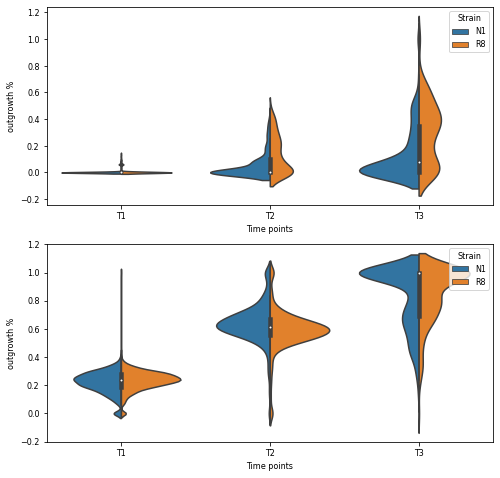

In [2031]:
fig,axes=plt.subplots(figsize=(8,8),nrows=2)
sns.violinplot(data=pole_stat_selected[pole_stat_selected['Antibiotics']=='INH'],x='Time points',y='outgrowth %',hue='Strain',ax=axes[0],split=True)
sns.violinplot(data=pole_stat_selected[pole_stat_selected['Antibiotics']=='N.C.'],x='Time points',y='outgrowth %',hue='Strain',ax=axes[1],split=True)

<Figure size 288x288 with 0 Axes>

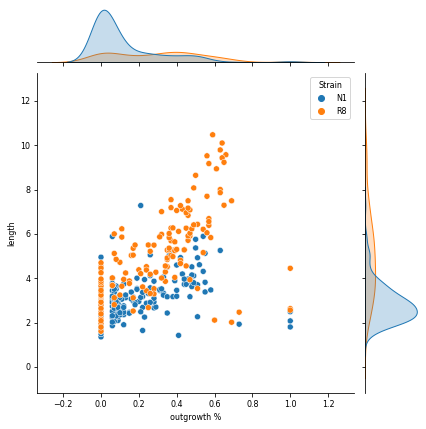

In [2029]:
cond1 = pole_stat_selected['Antibiotics']=='INH'
cond2 = pole_stat_selected['Time points']=='T3'
subset = pole_stat_selected[cond1&cond2]
fig=plt.figure(figsize=(4,4))
sns.jointplot(data=subset,x='outgrowth %',y='length',hue='Strain')

## Re-plotted by QL